In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os, sys, time
sys.path.append('../laba')
%matplotlib inline
from RegexParser import RegexParser
from SMCParser import SMCParser
from LexParser import LexParser


In [2]:
def test(laba, fileName='./timing.txt', splits_num=10, iters=25):
  pd_res = None
  with open(fileName, 'r', encoding='UTF-8') as inp:
    for i, line in enumerate(inp):
      pass
    lines_num = i+1

    inp.seek(0)
    splits = np.linspace(0, lines_num, splits_num)[1:]
    lines = inp.readlines()
    for sp in splits:
      a = []
      ed = int(sp)
      for j in range(iters):
        start = time.time_ns()
        for line in lines[:ed]:
          laba.parse(line)
        end = time.time_ns()
        a.append(end-start)

      res = {f'{ed}':a}
      tmp = pd.DataFrame.from_dict(res)
      tmp = tmp.sort_values(tmp.columns[0],ignore_index=True)    
      
      if pd_res is None:
        pd_res = tmp
      else:
        pd_res = pd.concat([pd_res, tmp], axis=1)
  pd_res
  return pd_res
        


In [3]:
smc = SMCParser()
regex = RegexParser()
lex = LexParser().build()

In [4]:
def graph(pds, names, name=''):
  plt.style.use('dark_background')
  # cmaps = plt.colormaps()
  colors = ['r','g','b']
  fig = plt.figure(figsize=(10,5))
  for i, p in enumerate(pds):
    yp = p/1e6
    y = yp.mean()
    x = y.index
    s = yp.std()
    plt.scatter(x, y, label=names[i], c=colors[i])
    plt.plot(x, y, colors[i])
    plt.fill_between(x, y-s, y+s, alpha=.33, color=colors[i])
  fig.legend()
  plt.ylabel('ms')
  plt.xlabel('rows')
  plt.title(name)

In [5]:
testFiles = sorted([i for i in os.listdir('../tests') if i.split('.')[-1] == 'test'])
testFiles

['03_10_2021_00_26_27__10000__20.test',
 '03_10_2021_00_26_34__10000__50.test',
 '03_10_2021_00_26_42__10000__100.test',
 '03_10_2021_00_26_51__10000__200.test',
 '03_10_2021_00_27_06__10000__500.test',
 '03_10_2021_00_31_11__10000__1000.test',
 'test1.test',
 'test2.test']

In [6]:
selectedTests = lambda i: (os.path.join('../tests/', testFiles[i]),lambda x: test(x, fileName=os.path.join('../tests/', testFiles[i])))

In [7]:
def doTest(i):
  labas = [smc, regex, lex]
  names = ['smc', 'regex', 'lex']
  name, testik = selectedTests(i)
  pds = list(map(testik, labas))
  graph(pds, names, name)

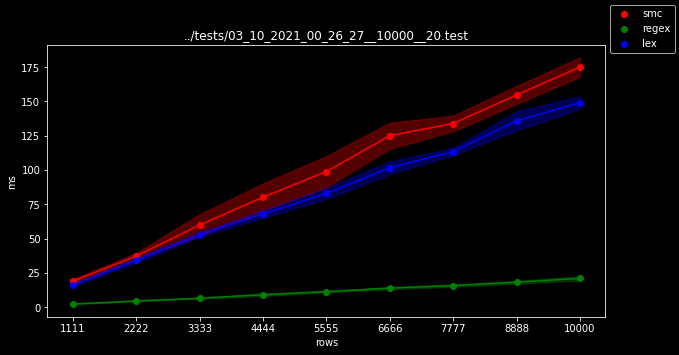

In [8]:
doTest(0)

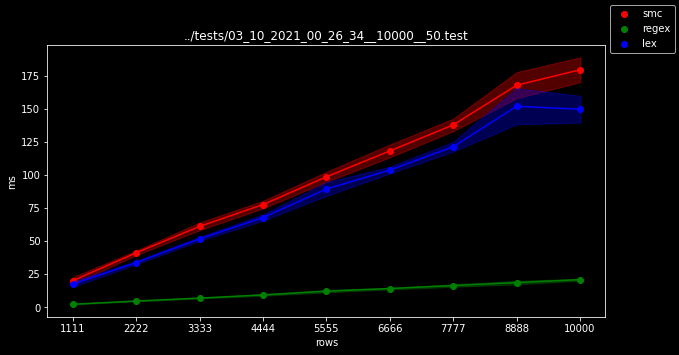

In [9]:
doTest(1)

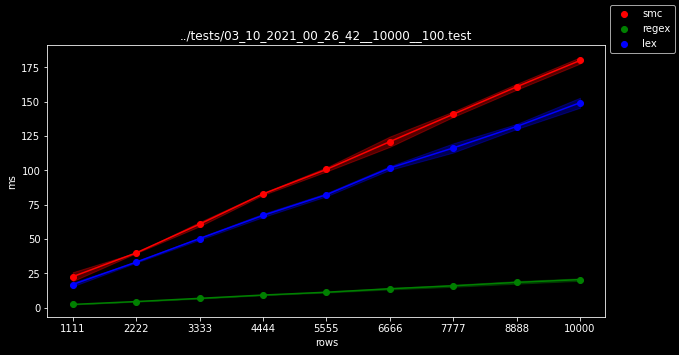

In [10]:
doTest(2)

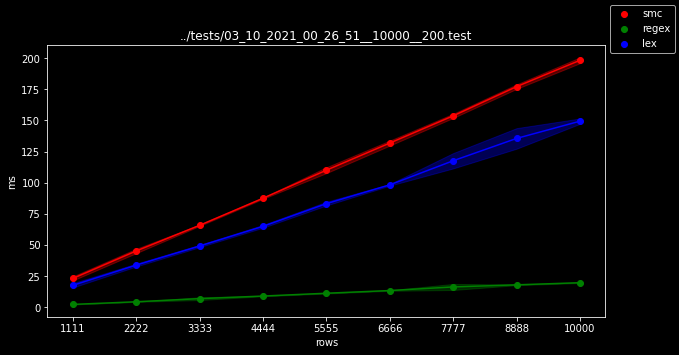

In [11]:
doTest(3)

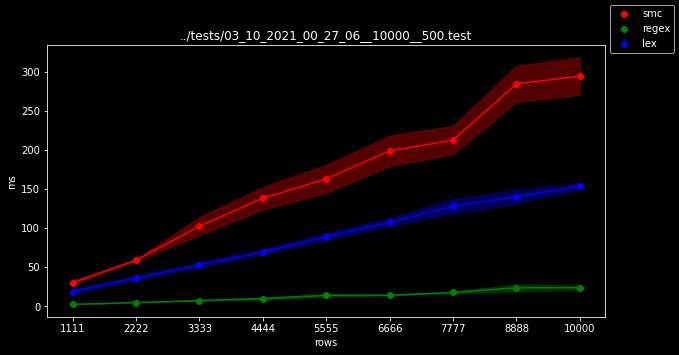

In [12]:
doTest(4)

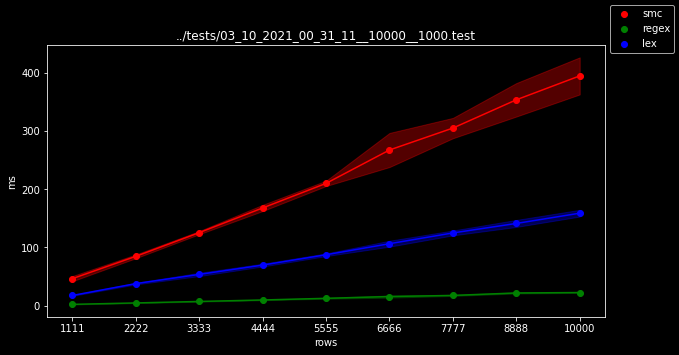

In [13]:
doTest(5)